In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_comparison, barplot_comparison, HandlerTupleVertical
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error,
                                    compute_avg_test_loglikelihood_vs_train_time_flows)
from cdi.util.stats_utils import load_statistics
from cdi.data.uci_hepmass import HEPMASSDataset

## Analysis setup

### Global settings

In [6]:
data_name = 'flows_uci'
flow_data = 'hepmass'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

eval_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/evaluations/tensors/{{}}'


## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_val(group, model, seed, val_ckpt, filename):
    path = log_path_template_val.format(group, model, seed, val_ckpt, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_val(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        for ckpt in val_ckpts[name]:
            name_i = f'{name} val{ckpt}'
            ckpt_name = f'{ckpt}_cust'
            try:
                stats[name_i] = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
    return stats

def read_suite_stats_val2(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        stats_i = defaultdict(list)
        for ckpt in val_ckpts[name]:
            try:
                ckpt_name = f'{ckpt}_cust'
                stat = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
                for k, v in stat.items():
                    # Append the last element from each key
                    stats_i[k].append(v[-1])
                stats_i['epoch'].append(ckpt)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
        stats[name] = stats_i
    return stats

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


def ma(a, ws=10):
    return np.convolve(a[::-1], np.ones(ws)/ws, mode='valid')[::-1]

In [9]:
# ggplot
colors = ['#000000', '#E24A33', #'#988ED5', '#34b9bd', '#FBC15E', 
          '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

## Generative model analysis

### Log-likelihood analysis

For each method train a number of models using the same complete dataset but different missingness generated by changing only the random seed for the missingness generator. The fitted models are then used to compute fully-observed average log-likelihood on a held-out test dataset. Finally, the results from different seeds are averaged and standard error is computed.

In [21]:
suite_line = {
    'RQ-Flow (Complete)': f'rqcspline_{flow_data}_complete_data',
}

suite_subsampled = {
    'RQ-Flow (Subsampled)': f'rqcspline_{flow_data}_complete_data_subsampled'
}


suite_bar = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
#     'VGI2': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss_2',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}
# groups = [1, 2, 3, 4, 5]
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


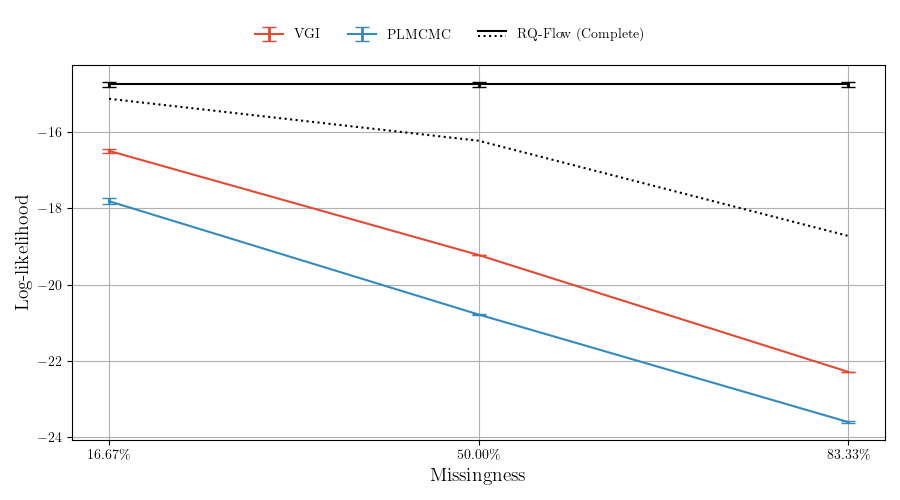

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
# axes.set(title=f'Test log-likelihood')

stats_line = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_line.items():
    stats_line[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                               seeds=exp_seed_keys,
                                                               groups=groups,
                                                               base_path=log_path_base)
plot_comparison(axes, stats_line,
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors,
#                 ylim=(450, 1200))
               )
    
stats_bar = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_bar.items():
        stats_bar[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                                  seeds=exp_seed_keys,
                                                                  groups=groups,
                                                                  base_path=log_path_base,
                                                                  ignore_notfound=True,
                                                             filename_suffix='_last')

# barplot_comparison(axes, stats_bar, width=0.09,
#                     x_metric_key='group',
#                     y_metric_keys=('test_log_lik',),  
#                     err_keys=('test_log_lik_stderr',),
#                     xlabel='Missingness',
#                     ylabel='Log-likelihood', 
#                     colors=colors[1:],
# #                     edgecolors=[None, 'red'] + [None]*(len(colors)-3),
# #                     ylim=(450, 1200),
#                       gap=0.03, gap_idxs=[2]
#                   )
plot_comparison(axes, stats_bar, 
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors[1:],
                ylim=None)

# for exp, model_name in suite_subsampled.items():
#     stat_sub = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                    seeds=exp_seed_keys,
#                                                    groups=groups,
#                                                    base_path=log_path_base)
    
#     for g in range(len(stat_sub['group'])):
#         axes.hlines(stat_sub['test_log_lik'], 
#                     xmin=np.array(stat_sub['group'])-0.5, 
#                     xmax=np.array(stat_sub['group'])+0.5,
#                     linestyles=[':'],
#                     colors=colors[:1])

stat_sub = {}
for exp, model_name in suite_subsampled.items():
    stat_sub[exp] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                   seeds=[exp_seed_keys[0]],
                                                   groups=groups,
                                                   base_path=log_path_base)
    
plot_comparison(axes, stat_sub, 
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors[:1],
                styles=[':'],
                ylim=None)

axes.set_xticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

# axes.grid()

fig.tight_layout(rect=(0, 0, 1, 0.90))

handles, labels = axes.get_legend_handles_labels()

handles = handles[1:-1] + [(mpl.lines.Line2D([0], [0], color=colors[0], linestyle='-'), 
                          mpl.lines.Line2D([0], [0], color=colors[0], linestyle=':'))]
# handles = handles[1:-1] + handles[:1]
labels = labels[1:-1] + labels[:1]

axes.legend(handles, labels,
            ncol=3, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})

In [15]:
# fig.savefig('figures/rqcspline_miniboone_test_loglik.pdf', bbox_inches='tight')

### Qualitative 

#### Correlation

<IPython.core.display.Javascript object>


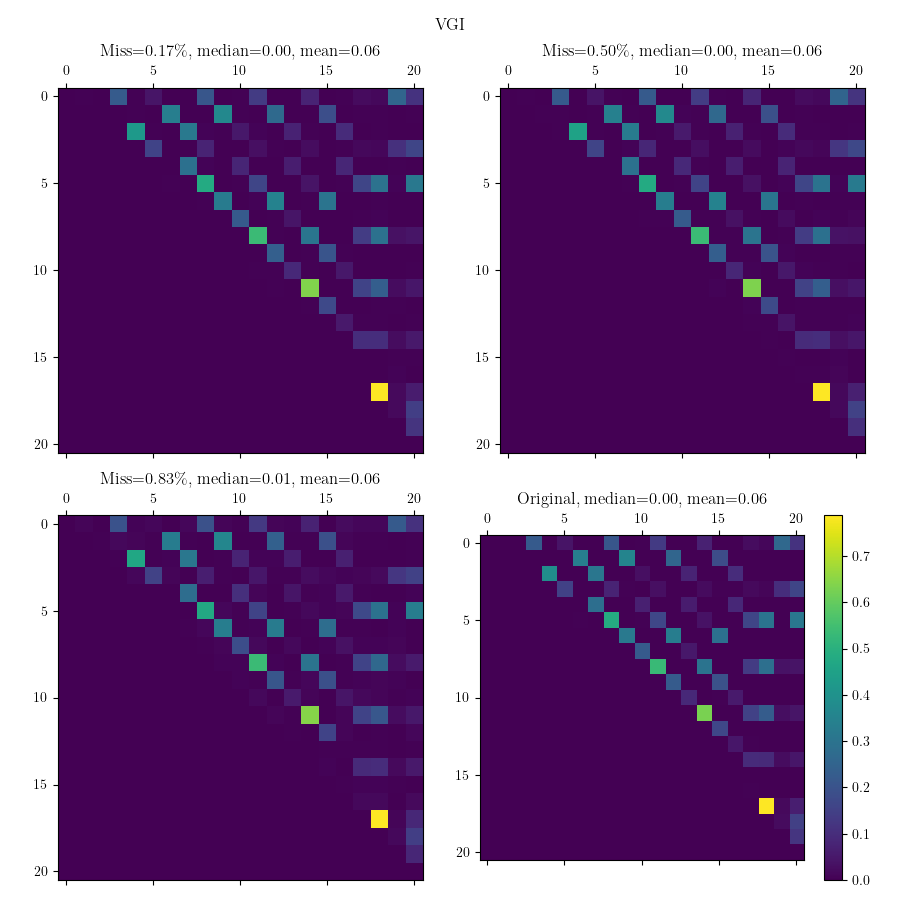

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

groups = [1,3,5]
method = f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss'
for i, g in enumerate(groups):
    try:
        path = eval_path_template.format(g, 
                                         method, 
                                         exp_seed_keys[0], 
                                         'flow_samples_test.npz')
        samples = np.load(path)

        corrmat = np.corrcoef(samples['samples'], rowvar=False)
        abs_corrmat = np.abs(corrmat)
        triang_indices = np.triu_indices_from(corrmat, k=1)
        median = np.median(abs_corrmat[triang_indices])
        mean = np.mean(abs_corrmat[triang_indices])
        
        idx = np.tril_indices_from(corrmat, k=0)
        abs_corrmat[idx] = 0

        axes[i].matshow(abs_corrmat, interpolation='nearest')

        axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')
    except FileNotFoundError:
        axes[i].set_title(f'Miss={g/6:.2f}\%, median=-, mean=-')

dataset = HEPMASSDataset(root='../../data', split='train')

corrmat = np.corrcoef(dataset.data, rowvar=False)
abs_corrmat = np.abs(corrmat)
triang_indices = np.triu_indices_from(corrmat, k=1)
median = np.median(abs_corrmat[triang_indices])
mean = np.mean(abs_corrmat[triang_indices])

idx = np.tril_indices_from(corrmat, k=0)
abs_corrmat[idx] = 0

cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  

fig.suptitle('VGI')

fig.tight_layout()
fig.colorbar(cax)


<IPython.core.display.Javascript object>


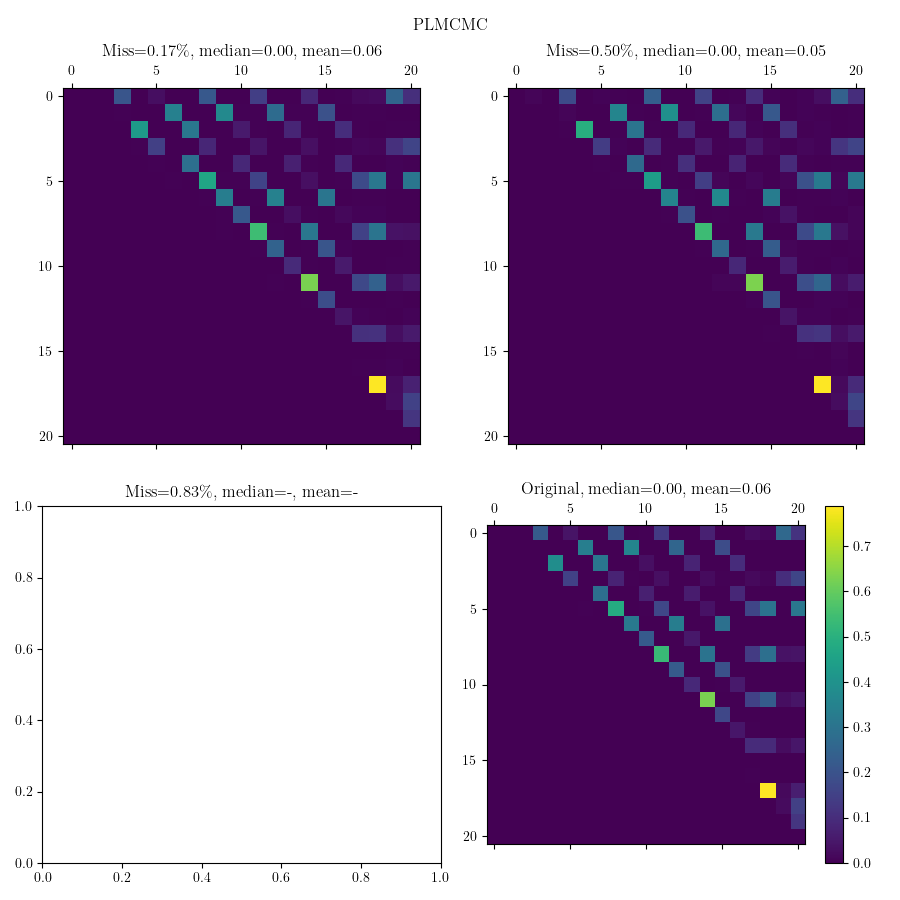

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

groups = [1,3,5]
method = f'rqcspline_{flow_data}_plmcmc'
for i, g in enumerate(groups):
    try:
        path = eval_path_template.format(g, 
                                         method, 
                                         exp_seed_keys[0], 
                                         'flow_samples_test.npz')
        samples = np.load(path)

        corrmat = np.corrcoef(samples['samples'], rowvar=False)
        abs_corrmat = np.abs(corrmat)
        triang_indices = np.triu_indices_from(corrmat, k=1)
        median = np.median(abs_corrmat[triang_indices])
        mean = np.mean(abs_corrmat[triang_indices])
        
        idx = np.tril_indices_from(corrmat, k=0)
        abs_corrmat[idx] = 0

        axes[i].matshow(abs_corrmat, interpolation='nearest')

        axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')
    except FileNotFoundError:
        axes[i].set_title(f'Miss={g/6:.2f}\%, median=-, mean=-')

dataset = HEPMASSDataset(root='../../data', split='train')

corrmat = np.corrcoef(dataset.data, rowvar=False)
abs_corrmat = np.abs(corrmat)
triang_indices = np.triu_indices_from(corrmat, k=1)
median = np.median(abs_corrmat[triang_indices])
mean = np.mean(abs_corrmat[triang_indices])

idx = np.tril_indices_from(corrmat, k=0)
abs_corrmat[idx] = 0

cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  

fig.suptitle('PLMCMC')

fig.tight_layout()
fig.colorbar(cax)


### Test-loglik vs train time

In [39]:
suite = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}

refit_ckpts = {
    'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
    'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
             380, 400, 420, 440, -1]],
}

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                       seeds=exp_seed_keys,
                                                                       ckpts=refit_ckpts[exp_name][i],
                                                                       group=g,
                                                                       base_path=log_path_base,
                                                                       ignore_notfound=True)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:],
                   ignore_nan=True)

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
# axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
#                frameon=False)


<IPython.core.display.Javascript object>

### Test-loglik vs train epoch vs train time

In [16]:
suite = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}

refit_ckpts = {
    'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
    'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
             380, 400, 420, 440, -1]],
}

<IPython.core.display.Javascript object>


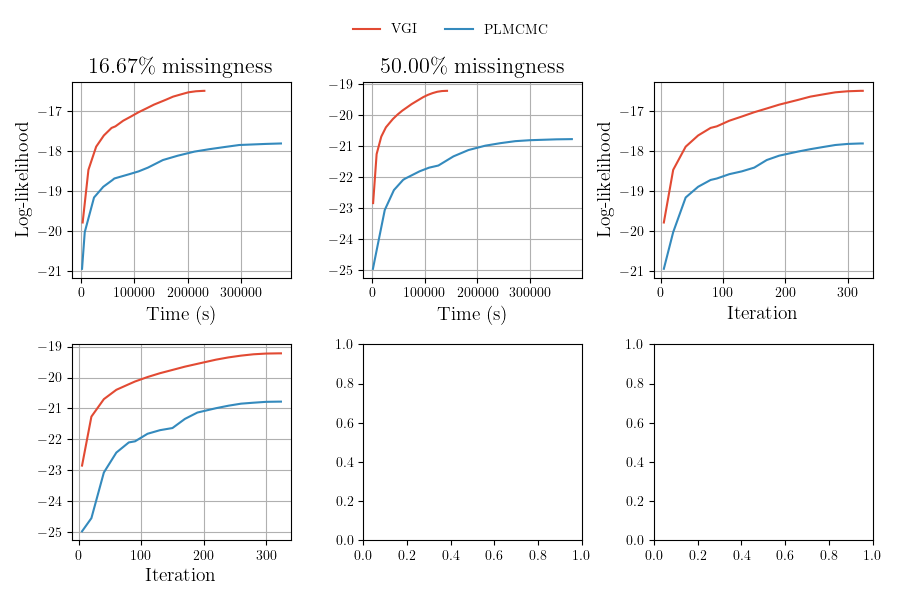

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(9, 6))
axes = axes.flatten()

gs = [1, 3, ]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                       seeds=exp_seed_keys,
                                                                       ckpts=refit_ckpts[exp_name][i],
                                                                       group=g,
                                                                       base_path=log_path_base,
                                                                       ignore_notfound=True)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    legend=False,
                    colors=colors[1:],
                   ignore_nan=True)
    
    xlabel = 'Iteration'
    
    plot_comparison(axes[i+len(gs)], stats, 
                    x_metric_key='epoch',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    legend=False,
                    colors=colors[1:],
                   ignore_nan=True)

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




### Test-loglik vs train epoch and avg train iteration time

In [25]:
suite = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}

refit_ckpts = {
    'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
    'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
             380, 400, 420, 440, -1]],
}

<IPython.core.display.Javascript object>


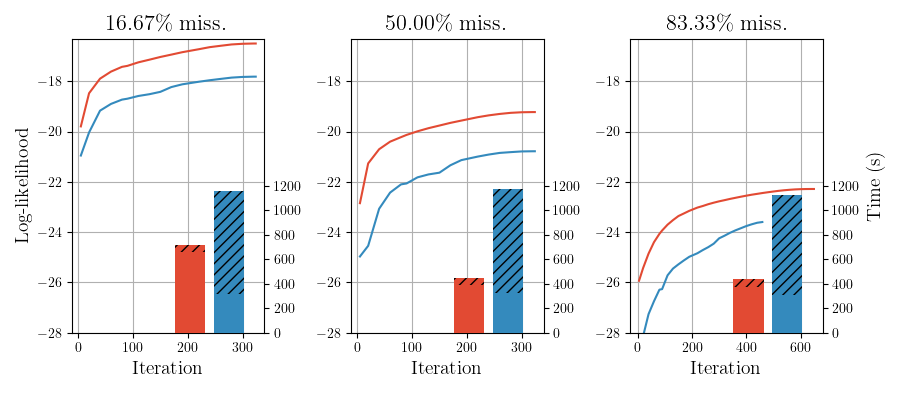

In [28]:
fig = plt.figure(constrained_layout=False, figsize=(9, 4))


axes_main = []
axes_sec = []
gs = [1, 3, 5]
time_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    # Add another subplot in the *same* location for curves
    axes_main.append(fig.add_subplot(1,3,i+1, label='Loglik vs Time'))
    # A subplot for the time bars
    axes_sec.append(fig.add_subplot(1,3,i+1, label='Time', frame_on=False))
    plt.setp(axes_sec[i].xaxis, label_position='top', ticks_position='top', visible=False)
    plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')
    
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    
    for m, s in stats_g.items():
        avg_train_time = np.array(s['train_time']).mean(axis=-1)
        avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
#         s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
        s['avg_train_time_minus_imp_time'].append(((np.array(s['train_time']) 
                                                    - np.array(s['train_imp_time'])).mean(axis=-1)).mean())
        s['avg_train_time'].append(avg_train_time.mean())
        s['avg_train_imp_time'].append(avg_imp_time.mean())
        s['dummy'] = [1]
        
    if i in (len(gs)-1, ):
        ylabel = 'Time (s)'
    else:
        ylabel=None
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_imp_time',),  
                        err_keys=(None,),
                        y_bott_keys=('avg_train_time_minus_imp_time',),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
                        hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_time_minus_imp_time',),  
                        err_keys=(None,),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    plt.setp(axes_sec[i], 
             xlim=(0.5, 1.2),
             ylim=(0, 2400))
    axes_sec[i].set_yticks([*range(0, 1200+1, 200)])
    
    
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                       seeds=exp_seed_keys,
                                                                       ckpts=refit_ckpts[exp_name][i],
                                                                       group=g,
                                                                       base_path=log_path_base,
                                                                       ignore_notfound=True)

    axes_main[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes_main[i], stats, 
                    x_metric_key='epoch',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:],
                   ignore_nan=True)
    
    plt.setp(axes_main[i], 
             ylim=(-28, -16.3))

fig.tight_layout()



### Test-loglik vs train epoch and avg train iteration time 2

In [25]:
suite = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}

refit_ckpts = {
    'VGI': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320,
                340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, -1]],
    'PLMCMC': [[5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, -1],
            [5, 20, 40, 60, 80, 90, 110, 130, 150, 170, 190, 220, 240, 260, 280, 300, 320, 340, 360,
             380, 400, 420, 440, -1]],
}

<IPython.core.display.Javascript object>


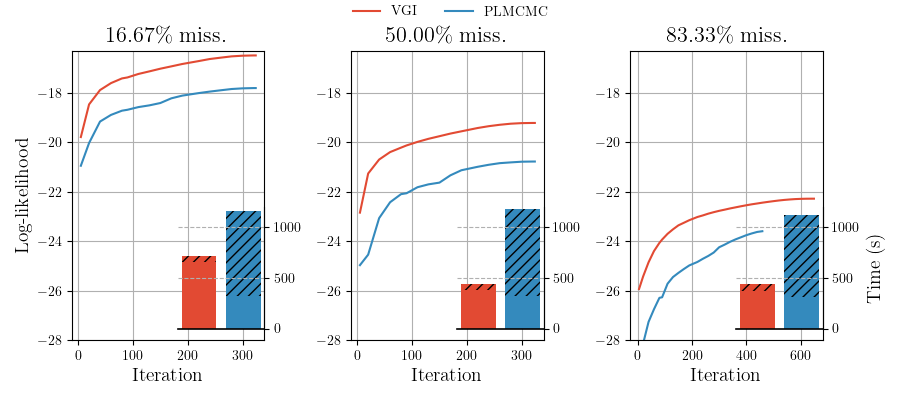

In [38]:
fig = plt.figure(constrained_layout=False, figsize=(9, 4))


axes_main = []
axes_sec = []
gs = [1, 3, 5]
time_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    # Add another subplot in the *same* location for curves
    axes_main.append(fig.add_subplot(1,3,i+1, label='Loglik vs Time'))
    # A subplot for the time bars
    axes_sec.append(axes_main[i].inset_axes([0.55, 0.04, 0.45, 0.42], zorder=2))
    plt.setp(axes_sec[i].xaxis, label_position='bottom', ticks_position='bottom')
    axes_sec[i].get_xaxis().set_ticks([])
    plt.setp(axes_sec[i].yaxis, label_position='right', ticks_position='right')
    
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    
    for m, s in stats_g.items():
        avg_train_time = np.array(s['train_time']).mean(axis=-1)
        avg_imp_time = np.array(s['train_imp_time']).mean(axis=-1)
#         s['avg_train_time_minus_imp_time'].append((avg_train_time - avg_imp_time).mean())
        s['avg_train_time_minus_imp_time'].append(((np.array(s['train_time']) 
                                                    - np.array(s['train_imp_time'])).mean(axis=-1)).mean())
        s['avg_train_time'].append(avg_train_time.mean())
        s['avg_train_imp_time'].append(avg_imp_time.mean())
        s['dummy'] = [1]
        
    if i in (len(gs)-1, ):
        ylabel = 'Time (s)'
    else:
        ylabel=None
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_imp_time',),  
                        err_keys=(None,),
                        y_bott_keys=('avg_train_time_minus_imp_time',),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
                        hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    barplot_comparison(axes_sec[i], stats_g, width=0.11,
                       gap=0.03, gap_idxs=[0],
                        x_metric_key='dummy',
                        y_metric_keys=('avg_train_time_minus_imp_time',),  
                        err_keys=(None,),
                        xlabel=None,
                        ylabel=ylabel, 
                        colors=colors[1:],
#                         hatches=['///']*3 + [None]*4,
#                         alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                       legend=False
                      )
    
    
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time_flows(model=model_name, 
                                                                       seeds=exp_seed_keys,
                                                                       ckpts=refit_ckpts[exp_name][i],
                                                                       group=g,
                                                                       base_path=log_path_base,
                                                                       ignore_notfound=True)

    axes_main[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes_main[i], stats, 
                    x_metric_key='epoch',
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:],
                   ignore_nan=True)
    
    plt.setp(axes_main[i], 
             ylim=(-28, -16.3))
    plt.setp(axes_sec[i], 
             ylim=(0, 1200))
#     axes_sec[i].set_xlabel("Method", fontsize=14)
    axes_sec[i].grid(linestyle='--')
    
    axes_sec[i].spines['left'].set_visible(False)
    axes_sec[i].spines['top'].set_visible(False)
    plt.setp(axes_sec[i].spines['bottom'], linewidth=1.2)
    
    axes_sec[i].patch.set_facecolor('#f0f0f0')
    axes_sec[i].patch.set_alpha(0.)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes_main[0].get_legend_handles_labels()
axes_main[0].legend(handles, labels,
            ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})
